# Agroforestry Segmentation System

## Production-Ready Semantic Segmentation for Cacao Agroforestry Systems

This notebook demonstrates a professional implementation of a deep learning-based semantic segmentation system designed for analyzing agroforestry landscapes, with a focus on cacao and shade tree species. The system uses a UNet architecture with a ResNet50 backbone to classify each pixel in high-resolution orthomosaic imagery into one of four classes:

- Background (non-forest areas)
- Cacao (main crop)
- Matarraton (shade tree species)
- Abarco (shade tree species)

This application can be used for:
- Quantifying forest composition and structure
- Monitoring agroforestry management practices
- Supporting sustainable agriculture decision-making
- Ecological studies of tropical agroforestry systems

The implementation is optimized for production environments with proper error handling, efficient memory management, and clear visualization capabilities.

## 1. Environment Setup

First, we'll ensure all necessary dependencies are installed. You may need to restart the kernel after installing these packages.

In [ ]:
# Install required packages if not already present
# !pip install rasterio opencv-python matplotlib segmentation-models-pytorch albumentations torch torchvision timm tqdm

## 2. Import Libraries

We import the necessary Python libraries and our custom modules for segmentation.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Import our custom modules
try:
    from MP.segmentation_model import SegmentationModel
    from MP.prediction_utils import predict_raster
    from MP.visualization import apply_color_mapping, get_color_palette
    from MP.utils import calculate_class_percentages
    logger.info("Successfully imported custom modules")
except ImportError as e:
    logger.error(f"Error importing custom modules: {e}")
    raise ImportError("Please ensure the MP package is properly installed and in your Python path.")

2025-05-07 19:57:13,573 - MP.backbone_manager - INFO - Added newer encoders from SMP 0.3.3+
2025-05-07 19:57:14,137 - __main__ - INFO - Successfully imported custom modules


## 3. Configuration

Set paths to input data and trained model, and define class labels.

In [14]:
# Define paths to input data and model weights
# Update these paths to match your environment
raster_path = "sample-data/test-24-01-2025_20mb.tif"
model_weights = "models/CacaoShadeClassification.pth"

# Verify files exist
if not os.path.exists(raster_path):
    raise FileNotFoundError(f"Input raster not found at: {raster_path}")
if not os.path.exists(model_weights):
    raise FileNotFoundError(f"Model weights not found at: {model_weights}")

# Define class labels for the segmentation model
classes = ['Background', 'Cacao', 'Matarraton', 'Abarco']
logger.info(f"Configured with {len(classes)} classes: {', '.join(classes)}")

# Set image size for prediction (adjust based on your GPU memory and raster resolution)
prediction_image_size = 2048

# Output configuration
output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)
output_filename = os.path.join(output_dir, "segmentation_result.png")

2025-05-07 20:00:52,614 - __main__ - INFO - Configured with 4 classes: Background, Cacao, Matarraton, Abarco


## 4. Model Initialization

Initialize the segmentation model with a UNet architecture using a ResNet50 backbone.

In [3]:
try:
    # Create segmentation model
    start_time = time.time()
    model = SegmentationModel(
        classes=classes,
        architecture='unet',      # UNet architecture for semantic segmentation
        encoder='resnet50',       # ResNet50 backbone for feature extraction
        weights=model_weights,    # Pre-trained weights
        loss='focal'              # Focal loss for handling class imbalance
    )
    logger.info(f"Model loaded in {time.time() - start_time:.2f} seconds")
    
    # Print model information
    print(f"Model Architecture: {model.architecture}")
    print(f"Encoder Backbone: {model.encoder}")
    print(f"Number of Classes: {model.n_classes}")
    print(f"Loss Function: {model.loss_name}")
    
except Exception as e:
    logger.error(f"Error initializing model: {e}")
    raise

2025-05-07 19:57:43,162 - MP.segmentation_model - INFO - Loading model from specified weights .pth file...
2025-05-07 19:57:47,436 - __main__ - INFO - Model loaded in 4.27 seconds


Model Architecture: unet
Encoder Backbone: resnet50
Number of Classes: 4
Loss Function: focal


## 5. Run Segmentation Inference

Process the input raster through the model to generate the segmentation map.

In [13]:
try:
    print("Running prediction on raster...")
    start_time = time.time()
    
    # Run inference with tiling for memory efficiency
    prediction = predict_raster(
        model_config=model,
        raster_path=raster_path,
        image_size=prediction_image_size,
        visualization='integer'  # Return raw class indices for flexible post-processing
    )
    
    inference_time = time.time() - start_time
    logger.info(f"Inference completed in {inference_time:.2f} seconds")
    
    # Basic verification of prediction output
    unique_classes = np.unique(prediction)
    print(f"Prediction shape: {prediction.shape}")
    print(f"Detected classes: {unique_classes}")
    
except Exception as e:
    logger.error(f"Error during inference: {e}")
    raise

2025-05-07 20:00:44,284 - MP.prediction_utils - INFO - Loading raster...
2025-05-07 20:00:44,406 - MP.utils - INFO - Adjusting dimensions to be divisible by 32: (1288x2048) → (1312x2048)
2025-05-07 20:00:44,406 - MP.prediction_utils - INFO - Processing with size: (1312H x 2048W)


Running prediction on raster...


2025-05-07 20:00:45,415 - MP.prediction_utils - INFO - Prediction raster written to: /home/jovyan/shared/Chima/ExtProjects/ForestCropClassification/sample-data/test-24-01-2025_20mb_predicted.tif
2025-05-07 20:00:45,416 - __main__ - INFO - Inference completed in 1.13 seconds


Prediction shape: (1632, 2594)
Detected classes: [0 1 2 3]


## 6. Load and Prepare Original Raster

Read the original orthomosaic for visualization alongside the segmentation results.

In [12]:
try:
    # Read original raster for visualization
    import rasterio
    with rasterio.open(raster_path) as src:
        print(f"Raster dimensions: {src.height}x{src.width}, {src.count} bands")
        print(f"CRS: {src.crs}")
        print(f"Transform: {src.transform}")
        
        # Read RGB bands (assuming they're the first 3 bands)
        original = src.read((1, 2, 3))
        
        # Transpose to height, width, channels format for visualization
        original = np.transpose(original, (1, 2, 0))
        
        # Normalize to 8-bit for visualization
        if original.max() > 255 or original.dtype != np.uint8:
            original = cv2.normalize(original, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Verify original image was loaded properly
    print(f"Original image shape: {original.shape}")
    print(f"Value range: {original.min()} to {original.max()}")
    
except Exception as e:
    logger.error(f"Error loading original raster: {e}")
    raise

Raster dimensions: 1632x2594, 4 bands
CRS: EPSG:32618
Transform: | 0.10, 0.00, 738634.88|
| 0.00,-0.10, 484882.39|
| 0.00, 0.00, 1.00|
Original image shape: (1632, 2594, 3)
Value range: 0 to 255


## 7. Calculate Statistics and Create Visualization

Generate class statistics and create a comprehensive visualization with the original image, segmentation map, and statistics.

Visualization saved to: ./output/segmentation_result.png


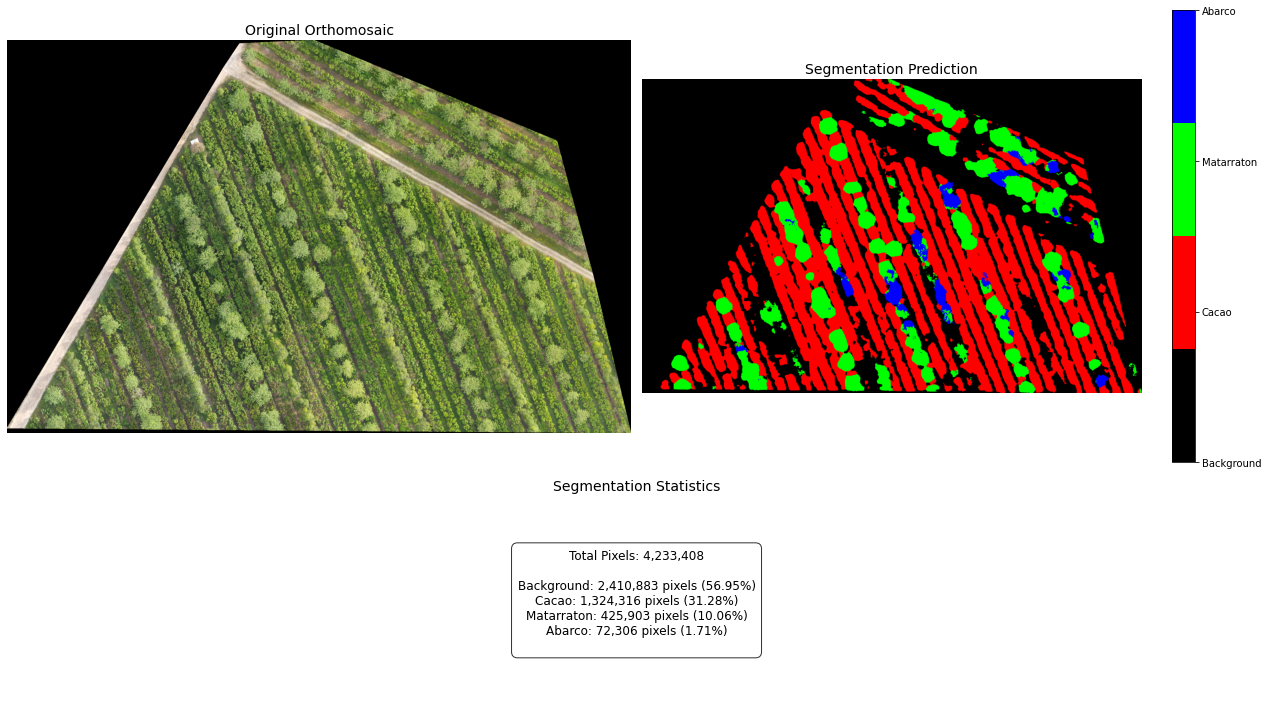

In [15]:
try:
    # Create color mapping for visualization
    color_palette = get_color_palette(len(classes))
    colored_prediction = apply_color_mapping(prediction, classes, color_palette)
    
    # Calculate class statistics
    stats = calculate_class_percentages(prediction, classes)
    
    # Create figure with subplots for a professional layout
    fig = plt.figure(figsize=(18, 10))
    
    # Original image (top left)
    ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
    ax1.set_title("Original Orthomosaic", fontsize=14)
    ax1.imshow(original)
    ax1.axis("off")
    
    # Prediction image (top right)
    ax2 = plt.subplot2grid((3, 2), (0, 1), rowspan=2)
    ax2.set_title("Segmentation Prediction", fontsize=14)
    im = ax2.imshow(colored_prediction)
    ax2.axis("off")
    
    # Add a colorbar legend
    cmap = ListedColormap([np.array(color)/255.0 for color in color_palette])
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax2, ticks=np.linspace(0, 1, len(classes)))
    cbar.set_ticklabels(classes)
    
    # Add statistics section at the bottom
    ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    ax3.axis("off")
    ax3.set_title("Segmentation Statistics", fontsize=14)
    
    # Format statistics text
    total_pixels = stats['total_pixels']
    stats_text = f"Total Pixels: {total_pixels:,}\n\n"
    
    # Sort classes by percentage (descending)
    sorted_classes = sorted(
        stats['classes'].items(), 
        key=lambda x: x[1]['percentage'], 
        reverse=True
    )
    
    # Add each class statistic
    for class_name, class_stats in sorted_classes:
        pixel_count = class_stats['pixel_count']
        percentage = class_stats['percentage']
        stats_text += f"{class_name}: {pixel_count:,} pixels ({percentage:.2f}%)\n"
    
    # Place text in the center of the subplot with a nice box
    ax3.text(0.5, 0.5, stats_text, ha='center', va='center', fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    # Save the visualization
    plt.savefig(output_filename, dpi=300, bbox_inches="tight")
    print(f"Visualization saved to: {output_filename}")
    
    # Display the visualization
    plt.show()
    
except Exception as e:
    logger.error(f"Error creating visualization: {e}")
    raise

## 8. Print Detailed Statistics

Output complete statistics to the console and save to a text file.

In [16]:
# Print statistics to console
print("\nSegmentation Statistics:")
print(f"Total pixels: {stats['total_pixels']:,}")
for class_name, class_stats in sorted_classes:
    print(f"  {class_name}: {class_stats['pixel_count']:,} pixels ({class_stats['percentage']:.2f}%)")

# Save statistics to text file
stats_file = os.path.join(output_dir, "segmentation_stats.txt")
with open(stats_file, 'w') as f:
    f.write(f"Segmentation Statistics for {os.path.basename(raster_path)}\n")
    f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: {model.architecture} with {model.encoder} encoder\n")
    f.write(f"Total pixels: {stats['total_pixels']:,}\n\n")
    
    for class_name, class_stats in sorted_classes:
        f.write(f"{class_name}: {class_stats['pixel_count']:,} pixels ({class_stats['percentage']:.2f}%)\n")

print(f"\nDetailed statistics saved to: {stats_file}")


Segmentation Statistics:
Total pixels: 4,233,408
  Background: 2,410,883 pixels (56.95%)
  Cacao: 1,324,316 pixels (31.28%)
  Matarraton: 425,903 pixels (10.06%)
  Abarco: 72,306 pixels (1.71%)

Detailed statistics saved to: ./output/segmentation_stats.txt


## 9. Export Segmentation as GeoTIFF (Optional)

Save the segmentation result as a GeoTIFF with the same spatial reference as the input.

In [17]:
# Optional: Save segmentation result as GeoTIFF
try:
    output_tif = os.path.join(output_dir, "segmentation_result.tif")
    
    with rasterio.open(raster_path) as src:
        # Copy metadata from source raster
        meta = src.meta.copy()
        
        # Update metadata for the output raster
        meta.update({
            'count': 1,
            'dtype': 'uint8',
            'compress': 'lzw',
            'nodata': None
        })
        
        # Write the prediction as a GeoTIFF
        with rasterio.open(output_tif, 'w', **meta) as dst:
            dst.write(prediction.astype(np.uint8), 1)
            print(f"Segmentation saved as GeoTIFF: {output_tif}")
except Exception as e:
    logger.error(f"Error saving segmentation as GeoTIFF: {e}")
    print(f"Could not save segmentation as GeoTIFF: {e}")

Segmentation saved as GeoTIFF: ./output/segmentation_result.tif
